In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, os, json, random

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, accuracy_score

# Import Data

In [3]:
def create_df(path, disp=True, n=1, offset=0):
    df_data, df_index = [], []
    i = 0
    for filename in os.listdir(path):
        name = filename.split('.')
        if name[-1] == 'json':

            # load data
            f = open(path + filename, 'r')
            content = f.read()
            a = json.loads(content)
            f.close()

            if not len(a['people']):
                continue
                
            # get the main person
            max_height = 0
            for p in a['people']:
                data = p['pose_keypoints_2d']

                # normalize
                coords = np.array([[n*data[i*3],data[i*3+1]] for i in range(25)])
                coords -= coords[1] # center around point 1
                coords /= max(abs(coords.reshape(-1))) # normalize

                # filter keypoints with poor confidence scores
                scores = [data[i*3+2] for i in range(25)]
                for k in range(len(scores)):
                    if not scores[k]:
                        coords[k] = [-1,-1]
                
                # get the tallest skeleton
                height = max(coords[:,1]) - min([k for k in coords[:,1] if k != -1])
                if height > max_height:
                    main_coords = coords

            # add to dataset
            df_index.append(i + offset)
            df_data.append(list(main_coords.reshape(-1)))
            i += 1

    df_data = np.array(df_data).T
    print(df_data.shape)
    
    df_dict = {}
    for i in range(25):
        df_dict['x'+str(i)] = [k for k in df_data[i*2]]
        df_dict['y'+str(i)] = [k for k in df_data[i*2+1]]
    df_dict['frame'] = df_index

    df = pd.DataFrame(df_dict)
    df.set_index('frame', inplace=True)
    df.sort_values(by=['frame'], inplace=True)
    if disp:
        display(df)
    
    return df

In [4]:
df = create_df('train_walking/', disp=False)
display(df)

(50, 1150)


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x20,y20,x21,y21,x22,y22,x23,y23,x24,y24
frame,,,,,,,,,,,,,,,,,,,,,
0,-1.000000,-1.000000,-1.0,-1.0,0.013294,0.852095,0.013326,0.941730,0.013319,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0.057469,-0.063243,0.0,0.0,-0.000031,-0.006301,-0.000004,0.108065,0.000048,0.203061,...,0.057588,0.488574,0.000166,0.501504,0.057642,0.507557,0.044666,0.514084,0.000189,0.501497
2,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,0.095770,-0.057171,0.0,0.0,-0.000108,-0.012558,-0.000145,0.070501,-0.000133,0.185180,...,0.057640,0.504769,-0.000029,0.517423,0.051342,0.517541,0.044619,0.523956,0.000011,0.511199
4,0.088442,-0.075794,0.0,0.0,-0.000052,-0.000319,-0.000077,0.081808,-0.000039,0.163782,...,0.050618,0.478870,-0.000004,0.485239,0.056803,0.485391,0.044100,0.491520,0.000031,0.485181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.039649,-0.025591,0.0,0.0,-0.002325,-0.002344,0.023371,0.051272,0.041926,0.002346,...,-0.081503,0.330567,-0.109317,0.298015,0.102490,0.328320,0.093170,0.332983,0.053598,0.330703
1146,0.039167,-0.023009,0.0,0.0,-0.002356,0.000012,0.027630,0.050735,0.046090,0.004551,...,-0.080706,0.325250,-0.096846,0.292942,0.092237,0.332040,0.082977,0.336660,0.043810,0.332154
1147,0.040958,-0.027288,0.0,0.0,-0.006836,-0.002239,0.027289,0.045490,0.045481,-0.000048,...,-0.079595,0.311734,-0.088710,0.279876,0.079511,0.325241,0.068247,0.329818,0.029589,0.327549


# Visualize Sequence

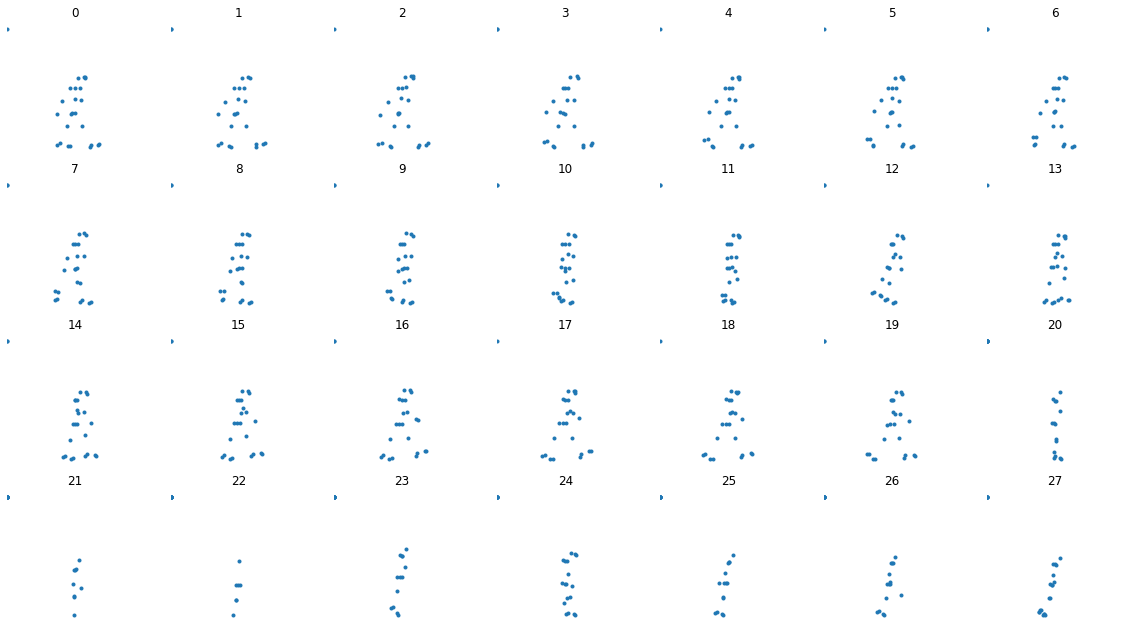

In [4]:
fig = plt.figure(figsize=(20,11))

for i in df.index[:28]:
    idx = list(df.index).index(i)
    x = [df.iloc[idx,k*2] for k in range(25)]
    y = [-df.iloc[idx,k*2+1] for k in range(25)] 
    fig.add_subplot(4, 7, idx+1)    
    plt.scatter(x, y, marker='.')
    plt.title(i)
    plt.xlim(-1,1)
    plt.axis("off")

plt.show()

# Load Dataset

In [5]:
timestep = 10
features = df.shape[1]

X, y = [], []
# walking data
for i in range(df.shape[0]//timestep):
    x = df.loc[timestep*i : timestep*(i+1)-1, :].to_numpy()
    X = np.dstack((X, x)) if i else x
    y.append(1) # walking
        
# non-walking data
for i in range(len(y)):
    rand = random.sample(range(df.shape[0]), timestep)
    X = np.dstack((X, df[df.index.isin(rand)].to_numpy()))
    y.append(0) # not walking

X = X.reshape(len(y), timestep, features) # (samples, timestep, features)
y = np.array(y)
print(X.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(x_train.shape, x_test.shape)

(230, 10, 50) (230,)
(184, 10, 50) (46, 10, 50)


# Train Model

In [33]:
def train(nodes, dense, opt='adam', verbose=True):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(nodes, return_sequences=True, input_shape=(timestep,features)))
    model.add(LSTM(nodes, return_sequences=False))
    model.add(Dense(dense))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, batch_size=8, epochs=50, validation_data=(x_test,y_test), verbose=verbose)
    
    return model, history

In [34]:
lstm, hist = train(nodes=20, dense=50, opt='adam')

Epoch 1/50
23/23 [==============================] - 6s 69ms/step - loss: 0.2529 - accuracy: 0.4837 - val_loss: 0.2524 - val_accuracy: 0.4348
Epoch 2/50
23/23 [==============================] - 0s 21ms/step - loss: 0.2503 - accuracy: 0.5054 - val_loss: 0.2510 - val_accuracy: 0.4130
Epoch 3/50
23/23 [==============================] - 0s 21ms/step - loss: 0.2474 - accuracy: 0.5598 - val_loss: 0.2557 - val_accuracy: 0.4130
Epoch 4/50
23/23 [==============================] - 0s 20ms/step - loss: 0.2411 - accuracy: 0.6413 - val_loss: 0.2555 - val_accuracy: 0.4348
Epoch 5/50
23/23 [==============================] - 0s 22ms/step - loss: 0.2366 - accuracy: 0.6033 - val_loss: 0.2703 - val_accuracy: 0.3913
Epoch 6/50
23/23 [==============================] - 0s 21ms/step - loss: 0.2225 - accuracy: 0.6576 - val_loss: 0.2809 - val_accuracy: 0.4130
Epoch 7/50
23/23 [==============================] - 0s 21ms/step - loss: 0.2042 - accuracy: 0.6957 - val_loss: 0.2860 - val_accuracy: 0.4130
Epoch 8/50
23

# Evaluate Model

In [35]:
def evaluate(model, history, show=True):
    # Prediction
    y_test_pred = model.predict(x_test).reshape(-1)

    # Get RMSE
    print('MSE:', mean_squared_error(y_test, y_test_pred))
    print('Accuracy:', accuracy_score(y_test, [1 if k>0.5 else 0 for k in y_test_pred]))
    
    if show:
        fig = plt.figure(figsize=(10,3))
        fig.add_subplot(1,2,1)
        plt.plot(history.history['loss'], label="Train")
        plt.plot(history.history['val_loss'], label="Validation")
        plt.legend()
        plt.xlabel('Epochs')
        plt.title('MSE')

        fig.add_subplot(1,2,2)
        plt.plot(history.history['accuracy'], label="Train")
        plt.plot(history.history['val_accuracy'], label="Validation")
        plt.legend()
        plt.xlabel('Epochs')
        plt.title('Accuracy')
        plt.show()

MSE: 0.39506879876361045
Accuracy: 0.5217391304347826


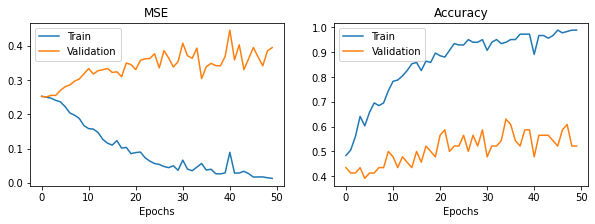

In [36]:
evaluate(lstm, hist)

# Hyperparameter Tuning

Node: 10
MSE: 0.41723309742865056
Accuracy: 0.5652173913043478


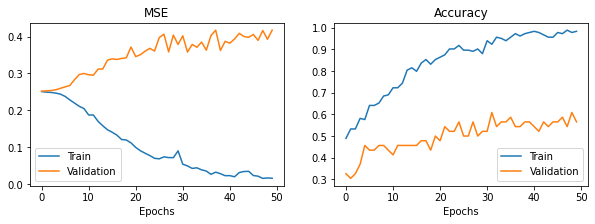

Node: 20
MSE: 0.4330473564959121
Accuracy: 0.5434782608695652


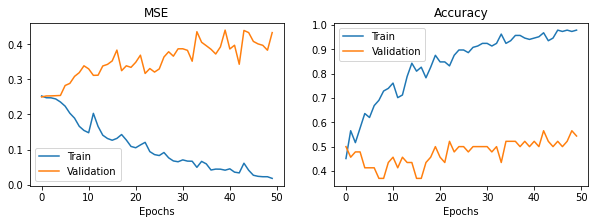

Node: 50
MSE: 0.5627861573003685
Accuracy: 0.41304347826086957


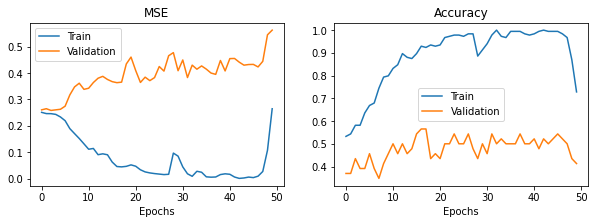

Node: 75
MSE: 0.48049409851381736
Accuracy: 0.4782608695652174


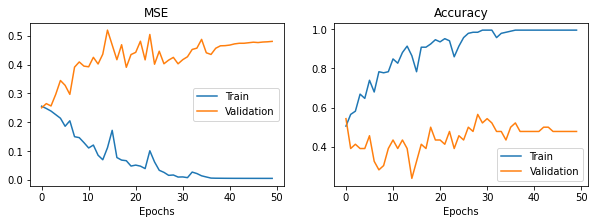

Node: 100
MSE: 0.49748805140997676
Accuracy: 0.45652173913043476


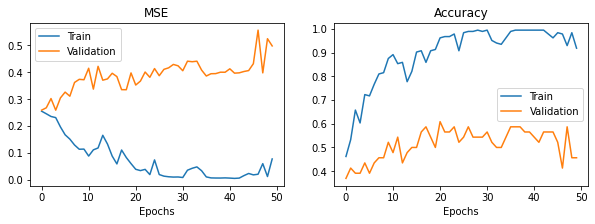

Node: 125
MSE: 0.4218047303671197
Accuracy: 0.5652173913043478


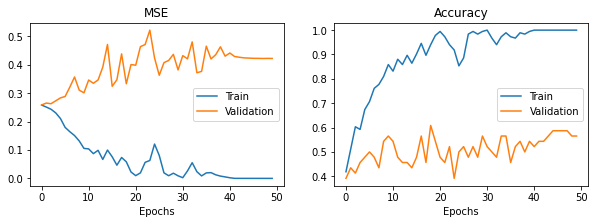

In [37]:
nodes = [10,20,50,75,100,125]
for node in nodes:
    print('Node:', node)
    lstm, hist = train(nodes=node, dense=25, opt='adam', verbose=False)
    evaluate(lstm, hist)

As ```nodes=10``` produces the best final validation accuracy, this value will be used to tune the number of nodes in the Dense layer.

Dense: 10
MSE: 0.33611426427748164
Accuracy: 0.6086956521739131


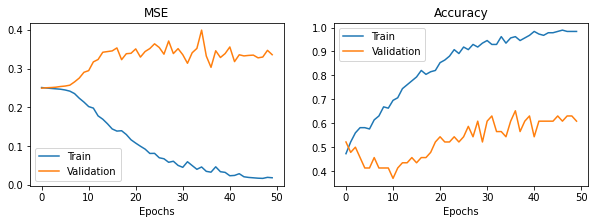

Dense: 25
MSE: 0.41509413203372897
Accuracy: 0.5652173913043478


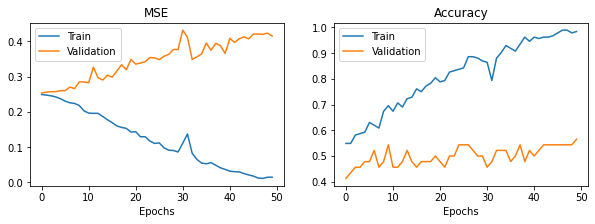

Dense: 50
MSE: 0.24582321500448887
Accuracy: 0.6521739130434783


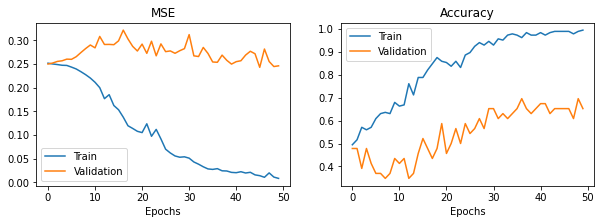

Dense: 75
MSE: 0.43042122127429455
Accuracy: 0.5217391304347826


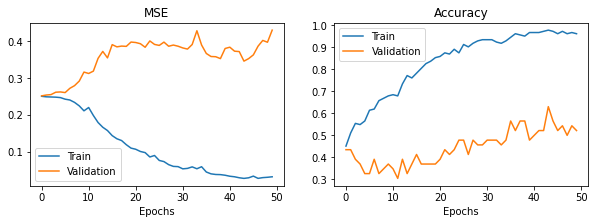

Dense: 100
MSE: 0.3473217756627261
Accuracy: 0.6304347826086957


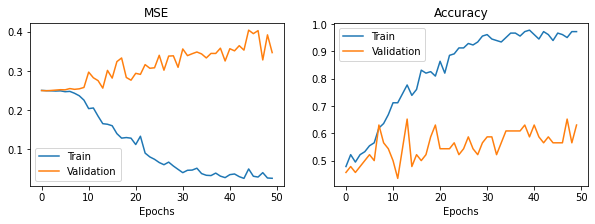

Dense: 125
MSE: 0.3931953942752821
Accuracy: 0.5434782608695652


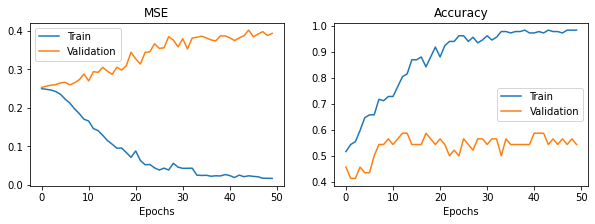

In [38]:
denses = [10,25,50,75,100,125]
for dense in denses:
    print('Dense:', dense)
    lstm, hist = train(nodes=10, dense=dense, opt='adam', verbose=False)
    evaluate(lstm, hist)

A dense layer with 75 nodes produces the best final validation accuracy.
The final model will thus have 10 nodes in the LSTM layer and 75 nodes in the Dense layer.

In [39]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 10, 10)            2440      
_________________________________________________________________
lstm_27 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_26 (Dense)             (None, 75)                825       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 76        
Total params: 4,181
Trainable params: 4,181
Non-trainable params: 0
_________________________________________________________________


# Test

In [12]:
test_df = create_df(path='test_walking/')

(50, 122)


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x20,y20,x21,y21,x22,y22,x23,y23,x24,y24
frame,,,,,,,,,,,,,,,,,,,,,
0,0.066932,-0.166597,0.0,0.0,-0.082970,0.000102,-0.141591,0.199937,-0.116639,0.408013,...,-0.149690,0.957899,-0.258071,0.891637,0.183361,0.983168,0.141490,1.000000,0.050155,0.991597
1,0.043718,-0.048942,0.0,0.0,0.005166,0.002547,0.002558,0.080087,0.018074,0.149759,...,-0.023335,0.345878,-0.069692,0.345786,0.141808,0.330407,0.136682,0.338109,0.097955,0.350980
2,0.043571,-0.048603,0.0,0.0,0.010145,0.000147,0.002530,0.081939,0.020487,0.148574,...,-0.030685,0.343205,-0.076794,0.338113,0.143448,0.327855,0.138290,0.335564,0.094816,0.348272
3,0.040478,-0.045633,0.0,0.0,0.005132,0.002504,0.002620,0.080831,0.017804,0.146705,...,-0.040403,0.341235,-0.088379,0.333758,0.136606,0.331181,0.128976,0.338843,0.083537,0.346357
4,0.042788,-0.047901,0.0,0.0,0.012496,0.002481,0.009964,0.080545,0.022713,0.148462,...,-0.042855,0.339576,-0.088103,0.327030,0.138379,0.339599,0.128235,0.347077,0.082997,0.347062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.048124,-0.048162,0.0,0.0,0.010714,0.002673,0.007920,0.077658,0.024128,0.152568,...,-0.002678,0.345382,-0.032119,0.361406,0.088369,0.374789,0.072290,0.380089,0.026729,0.358752
118,0.047524,-0.050318,0.0,0.0,0.007820,0.002683,0.005151,0.076820,0.023725,0.150974,...,-0.002758,0.354884,-0.045045,0.357566,0.103293,0.365546,0.092626,0.370862,0.047670,0.365449
119,0.042084,-0.047256,0.0,0.0,0.007884,0.002672,0.002546,0.076219,0.018409,0.152391,...,-0.007973,0.354805,-0.052624,0.357372,0.126136,0.357383,0.115523,0.365232,0.068283,0.365265


In [40]:
model, hist = train(nodes=10, dense=50, opt='adam', verbose=False)
evaluate(model, hist, show=False)

MSE: 0.3433450060314621
Accuracy: 0.6086956521739131


In [55]:
correct, total = 0, 0
for start in range(test_df.shape[0] - timestep):
    total += 1
    data = test_df.loc[start : start+timestep-1, :].to_numpy().reshape(1, timestep, features)
    pred = model.predict(data)
    if pred > 0.5:
        correct += 1
#     print('Pred = %.4f. %s' % (pred[0], 'Walking' if pred[0]>0.5 else 'Not walking'))

print('Accuracy: %.4f' % (correct/total))
print('%d / %d frames correctly identified' % (correct, total))

Accuracy: 0.4821
54 / 112 frames correctly identified
